## Applied DL Final Project

### Group Members:

####  1. Avijit Shah (as5623)
####  2. Saurav Singh Dhakad (ssd2158)

In [1]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python
!pip install keras-hist-graph

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

import math
import tensorflow as tf
import random
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from keras.applications.resnet50 import ResNet50
from tensorflow.metrics import mean_iou

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
!ls /content/gdrive/'My Drive'/slides

 tumor_001_mask.tif   tumor_031.xml	   tumor_081.tif
 tumor_001.tif	      tumor_035_mask.tif   tumor_081.xml
 tumor_001.xml	      tumor_035.tif	   tumor_084_mask.tif
 tumor_002_mask.tif   tumor_035.xml	   tumor_084.tif
 tumor_002.tif	     'tumor_038 (1).xml'   tumor_084.xml
 tumor_002.xml	      tumor_038.tif	   tumor_091_mask.tif
 tumor_005_mask.tif   tumor_038.xml	   tumor_091.tif
 tumor_005.tif	      tumor_057_mask.tif   tumor_091.xml
 tumor_005.xml	      tumor_057.tif	   tumor_094_mask.tif
 tumor_012_mask.tif   tumor_057.xml	   tumor_094.tif
 tumor_012.tif	      tumor_059_mask.tif   tumor_094.xml
 tumor_012.xml	      tumor_059.tif	   tumor_096_mask.tif
 tumor_016_mask.tif   tumor_059.xml	   tumor_096.tif
 tumor_016.tif	      tumor_064_mask.tif   tumor_096.xml
 tumor_016.xml	      tumor_064.tif	   tumor_099.xml
 tumor_019_mask.tif   tumor_064.xml	   tumor_101_mask.tif
 tumor_019.tif	      tumor_075_mask.tif   tumor_101.tif
 tumor_019.xml	      tumor_075.tif	   tumor_101.xml
 tumor_02

In [0]:
FilePath = '/content/gdrive/My Drive/slides/'

In [6]:
#Getting data train and test
def get_slide_info(slide_path, tumor_mask_path):
  slide = open_slide(slide_path)
  print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                          slide.level_dimensions[0][0], 
                                                          slide.level_dimensions[0][1]))

  tumor_mask = open_slide(tumor_mask_path)
  print ("Read tumor mask from %s" % (tumor_mask_path))

  print("Slide includes %d levels", len(slide.level_dimensions))
  for i in range(len(slide.level_dimensions)):
      print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                               slide.level_dimensions[i], 
                                                               slide.level_downsamples[i]))
      #assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]   #There are some images where mask is not present at level 7
      #assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]   #There are some images where mask is not present at level 7

  #Verify downsampling works as expected
  width, height = slide.level_dimensions[7]
  assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
  assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]
 
  print("=========================================================")
  return slide, tumor_mask



#setting train and test files
names_train_images = ['tumor_091.tif'] #,'tumor_075.tif','tumor_084.tif'
names_train_masks = ['tumor_091_mask.tif'] #,'tumor_075_mask.tif','tumor_084_mask.tif'
names_test_images = ['tumor_110.tif','tumor_078.tif','tumor_101.tif']#,'tumor_110.tif','tumor_078.tif','tumor_084.tif', tumor_101.tif
names_test_masks = ['tumor_110_mask.tif','tumor_078_mask.tif','tumor_101_mask.tif']#,'tumor_110_mask.tif','tumor_078_mask.tif','tumor_101_mask.tif'


list_train_images = []
list_train_masks = []
list_test_images = []
list_test_masks = []


for i in range(len(names_train_images)):
  image_path = FilePath + names_train_images[i]
  mask_path = FilePath + names_train_masks[i]
  slide, tumor_mask = get_slide_info(image_path,mask_path)
  list_train_images.append(slide)
  list_train_masks.append(tumor_mask)

for i in range(len(names_test_images)):
  image_path = FilePath + names_test_images[i]
  mask_path = FilePath + names_test_masks[i]
  slide, tumor_mask = get_slide_info(image_path,mask_path)
  list_test_images.append(slide)
  list_test_masks.append(tumor_mask)
  
print("Train Images:",len(list_train_images), len(list_train_masks),"Test Images:", len(list_test_images), len(list_test_masks))


Read WSI from /content/gdrive/My Drive/slides/tumor_091.tif with width: 61440, height: 53760
Read tumor mask from /content/gdrive/My Drive/slides/tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128
Read WSI from /content/gdrive/My Drive/slides/tumor_110.tif with width: 94208, height: 71680
Read tumor mask from /content/gdrive/My Drive/slides/tumor_110_mask.tif
Slide includes %d levels 9
Level 0, dimensions: (94208, 71680) downsample factor 1
Level 1, dimensions: (47104, 35840) downsample factor 2
Level 2, dimensions: (23552, 17920) downsample factor 4
Level 3, 

In [0]:
# Read a region from the slide
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [0]:
def plot_figure(image, mask):    
  plt.figure(figsize=(3,3), dpi=100)
  
  if(image is not None):
    plt.imshow(image)
  if(mask is not None):
    plt.imshow(mask, cmap='jet', alpha=0.5)

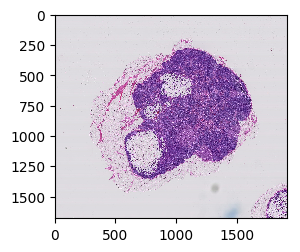

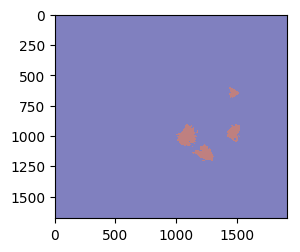

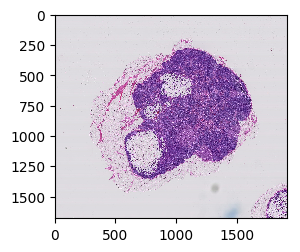

In [9]:
levels = [3, 4, 5]  #set the level or levels of train and test image
train_images = []
train_mask = []
for i,level in enumerate(levels):
  train_images_level = []
  train_mask_level = []
  for i in range(len(list_train_images)):
    slide = list_train_images[i]
    tumor_mask = list_train_masks[i]
    slide_image_train = read_slide(slide, x=0,y=0,level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])
                         
    mask_image_train = read_slide(tumor_mask,x=0,y=0,level=level,
                        width=slide.level_dimensions[level][0], 
                        height=slide.level_dimensions[level][1])
    
    mask_image_train = mask_image_train[:,:,0]
    
    train_images_level.append(slide_image_train)
    train_mask_level.append(mask_image_train)
  train_images.append(train_images_level)
  train_mask.append(train_mask_level)
    

plot_figure(image = train_images[-1][0], mask = None)
plot_figure(image=None, mask = train_mask[-1][0])
plot_figure(train_images[-1][0], train_images[-1][0])

    


In [0]:
#list_train_images = None
#list_train_masks = None
#list_test_images = None
#list_test_masks = None

In [0]:
#n = test_images[0].shape[1]//100  #n is the number of patches in a row; used later for gnerating heatmap in the end

Generating small patches

In [0]:
#setting patch size to 100, center_patch size where cells of slide image and mask compared is 60! move_by = 60 while training to get more samples, move_by = 100 to get continuous patches 
def set_variables(test=False):
  if(test):
    move_by = 100 #no overlap while choosing patches
  else:
    move_by = 60 #more data while training with stride of 128
  patch_width, patch_height = 100, 100
  center_patch = 60
  lower = int(math.floor(move_by-center_patch)/2)
  upper = int(math.ceil(move_by-center_patch)/2)
  
  return move_by, patch_width, patch_height, center_patch, lower, upper

In [0]:
#when test = true, taking continuous patches from the slide with no overlap
def get_slide_images(list_slide_image, list_mask_image, test=False):
  patch,patch_width,patch_height,center,lower,upper =  set_variables(test=test)
  images = []
  labels = []
  for i,slide_image in enumerate(list_slide_image):
    print(slide_image.shape)
    width, height = slide_image.shape[0], slide_image.shape[1]
    for x in range(0, width - patch_width + 1, patch):
      for y in range(0, height - patch_height + 1, patch):
        image = slide_image[x: x + patch_width, y:y+patch_height, :]
        images.append(image)
        label = 1 if list_mask_image[i][x + lower: x + patch_width - upper, y+lower: y + patch_height - upper].sum() > 0 else 0
        labels.append(label)
  images = np.asarray(images)
  labels = np.asarray(labels)
  return images, labels

In [0]:
def get_slide_images_test(slide_image, mask_image, test=False):
  patch,patch_width,patch_height,center,lower,upper =  set_variables(test=test)
  images = []
  labels = []
  print(slide_image.shape)
  width, height = slide_image.shape[0], slide_image.shape[1]
  for x in range(0, width - patch_width + 1, patch):
    for y in range(0, height - patch_height + 1, patch):
      image = slide_image[x: x + patch_width, y:y+patch_height, :]
      images.append(image)
      label = 1 if mask_image[x + lower: x + patch_width - upper, y+lower: y + patch_height - upper].sum() > 0 else 0
      labels.append(label)
  images = np.asarray(images)
  labels = np.asarray(labels)
  return images, labels

In [13]:
#getting training samples patches
x_train = [0]*len(train_images)
y_train = [0]*len(train_images)
for i in range(len(train_images)):
  x_train[i], y_train[i] = get_slide_images(train_images[i], train_mask[i], test=False)
  print("Train Sample", i)
  print(x_train[i].shape, y_train[i].shape)
  print("\n")

(6720, 7680, 3)
Train Sample 0
(14097, 100, 100, 3) (14097,)


(3360, 3840, 3)
Train Sample 1
(3465, 100, 100, 3) (3465,)


(1680, 1920, 3)
Train Sample 2
(837, 100, 100, 3) (837,)




In [0]:
#freeing up the memory
#train_images = None
#train_mask = None

In [0]:
"""
#getting test_sample patches
x_test, y_test = get_slide_images(test_images,test_mask,test=True)
x_test.shape, len(y_test), y_test.shape
"""

In [0]:
#test_images = None
#test_mask = None

In [14]:
#checking the size of each sample
from collections import Counter

for i in range(len(y_train)):
  print("Train Sample", i, "negative and positive:")
  print(Counter(y_train[i]).keys())
  print(Counter(y_train[i]).values())
  print("\n")

Train Sample 0 negative and positive:
dict_keys([0, 1])
dict_values([13729, 368])


Train Sample 1 negative and positive:
dict_keys([0, 1])
dict_values([3333, 132])


Train Sample 2 negative and positive:
dict_keys([0, 1])
dict_values([784, 53])




In [15]:
for i in range(len(y_train)):
  print("train sample", i)
  print(np.where(y_train[i]==1)[0])

train sample 0
[ 5047  5048  5049  5050  5174  5175  5176  5177  5178  5302  5303  5304
  5305  5306  5307  5429  5430  5431  5432  5433  5434  5555  5556  5557
  5558  5559  5560  5561  5683  5684  5685  5686  5687  5688  5809  5810
  5811  5812  5813  5936  5937  5938  7565  7566  7591  7592  7593  7690
  7691  7692  7693  7694  7695  7696  7716  7717  7718  7719  7720  7721
  7816  7817  7818  7819  7820  7821  7822  7823  7842  7843  7844  7845
  7846  7847  7848  7943  7944  7945  7946  7947  7948  7949  7950  7951
  7952  7968  7969  7970  7971  7972  7973  7974  7975  8069  8070  8071
  8072  8073  8074  8075  8076  8077  8078  8079  8094  8095  8096  8097
  8098  8099  8100  8101  8102  8194  8195  8196  8197  8198  8199  8200
  8201  8202  8203  8204  8205  8206  8221  8222  8223  8224  8225  8226
  8227  8228  8229  8321  8322  8323  8324  8325  8326  8327  8328  8329
  8330  8331  8332  8333  8348  8349  8350  8351  8352  8353  8354  8355
  8356  8448  8449  8450  8451  8452

In [0]:
def oversampling(images, labels):
  num = int(len(labels) - labels.sum())
  indices = np.where(labels==1)[0]
  
  oversample_ind = np.random.choice(indices, size=num, replace=True)
  x = np.append(images[oversample_ind], images[np.where(y_train==0)], axis=0)
  y = np.append(labels[oversample_ind], labels[np.where(y_train==0)])
  x,y = shuffle(x,y, random_state = 42)
  print(x.shape, y.shape)
  print('tumor percent: {}'.format(y.sum()/float(len(y))))
  return x,y

In [0]:
def undersampling(images, labels):
  num = int(labels.sum())
  tumor_indices = [i for i, x in enumerate(labels) if x==1]
  normal_indices = [i for i, x in enumerate(labels) if x==0]
  tumor_images = []
  normal_images = []
  for i in tumor_indices:
    tumor_images.append(images[i])
  for i in normal_indices:
    normal_images.append(images[i])
  normal_images = random.sample(normal_images, num)
  
  x = np.vstack((normal_images, tumor_images))
  y = np.hstack(([0]*num, [1]*num))
  x,y = shuffle(x,y, random_state = 42)
  print(x.shape, y.shape)
  print("tumor percent: {}".format(y.sum()/float(len(y))))
  return x,y

In [0]:
"""
#vgg callbacks list
  
model_cp_vgg = tf.keras.callbacks.ModelCheckpoint('model_vgg.hdf5',
                              monitor='val_acc',
                              verbose=1,
                              save_best_only=True,
                              save_weights_only=False,
                              mode='max',
                              period=1)

early_stopping_vgg = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0,
                                  patience=1,
                                  verbose=1,
                                  mode='auto')

callbacks_list_vgg = [model_cp_vgg, early_stopping_vgg]
"""

In [0]:

#model
def model_top(base, x_train, y_train):
  model = tf.keras.Sequential([
      base,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')])
  
  model.compile(optimizer = tf.train.AdamOptimizer(),
               loss = 'binary_crossentropy',
               metrics=['acc'])
  model.summary()
  history_callback = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.1) #avi: changed this line, , callbacks=callbacks_list_vgg 
 
  return model, history_callback
  
  

In [19]:
#Set oversampling or undersampling
OVERSAMPLING = False
UNDERSAMPLING = True

x_train_new = [0]*len(x_train)
y_train_new = [0]*len(x_train)
for i in range(len(x_train)):
  if(OVERSAMPLING):
    x_train_new[i], y_train_new[i] = oversampling(x_train[i], y_train[i])
  if(UNDERSAMPLING):
    x_train_new[i], y_train_new[i] = undersampling(x_train[i], y_train[i])

(736, 100, 100, 3) (736,)
tumor percent: 0.5
(264, 100, 100, 3) (264,)
tumor percent: 0.5
(106, 100, 100, 3) (106,)
tumor percent: 0.5


In [0]:
#plot to compare the training and validation error
def plot_history(history_vgg):
  acc_vgg = history_vgg.history['acc']
  val_acc_vgg = history_vgg.history['val_acc']
  loss_vgg = history_vgg.history['loss']
  val_loss_vgg = history_vgg.history['val_loss']

  # Get the number of epochs
  epochs_vgg = range(1,len(acc_vgg)+1)

  plt.title('Training and validation accuracy')
  plt.plot(epochs_vgg, acc_vgg, color='blue', label='Train')
  plt.plot(epochs_vgg, val_acc_vgg, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs_vgg, loss_vgg, color='blue', label='Train')
  plt.plot(epochs_vgg, val_loss_vgg, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

In [21]:
base_vgg = tf.keras.applications.VGG16(weights='imagenet',
                                      include_top = False, input_shape=(100, 100, 3))
base_vgg.trainable = False


Instructions for updating:
Colocations handled automatically by placer.


In [22]:
model_path = []
for i in range(len(x_train_new)):
  model_vgg, history_vgg = model_top(base_vgg, x_train_new[i], y_train_new[i])
  model_name = "model_vgg_" + str(i)
  model_path.append(tf.contrib.saved_model.save_keras_model(model_vgg, model_name))
  print("Model Path:", model_path[i])
  #plot_history(history_vgg)
  print("===================================================\n\n")


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 14,780,481
Trainable params: 65,793
Non-trainable params: 14,714,688
_________________________________________________________________
Train on 662 samples, validate on 74 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
662/662 [==============================] - 4s 7ms/sample - loss: 0.7217 - acc: 0.8399 - val_loss: 0.8071 - val_acc: 0.7973
Epoch 2/10
662/662 [==========

In [0]:
loaded_models = [0]*len(y_train_new)
for i in range(len(y_train_new)):
  loaded_models[i] = tf.contrib.saved_model.load_keras_model(model_path[i])
  loaded_models[i].compile(optimizer=tf.train.AdamOptimizer(learning_rate=1e-4), loss='binary_crossentropy', metrics=['acc'])

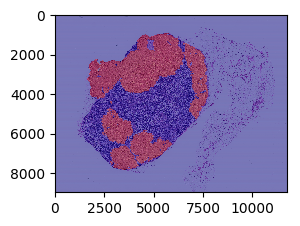

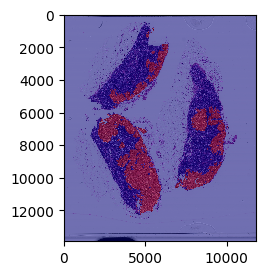

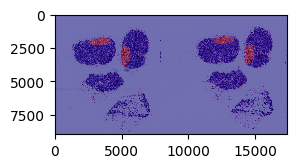

In [24]:
levels_test = [3]  
test_images = []
test_mask = []
for level in levels_test:
  for i in range(len(list_test_images)):
    slide = list_test_images[i]
    tumor_mask = list_test_masks[i]
    slide_image_test = read_slide(slide, x=0,y=0,level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])
                         
    mask_image_test = read_slide(tumor_mask,x=0,y=0,level=level,
                        width=slide.level_dimensions[level][0], 
                        height=slide.level_dimensions[level][1])
    
    mask_image_test = mask_image_test[:,:,0]
    
    test_images.append(slide_image_test)
    test_mask.append(mask_image_test)
    #plot_figure(image = slide_image_test, mask = None)
    #plot_figure(image=None, mask = mask_image_test)
    plot_figure(slide_image_test, mask_image_test)
    


In [25]:
print(len(test_images))

3


In [26]:
x_test = [0]*len(test_images)
y_test = [0]*len(test_images)
for i in range(len(test_images)):
  x_test[i], y_test[i] = get_slide_images_test(test_images[i], test_mask[i], test=True)  #train is list of list and test is just list, thus a little change in the way variable is sent
  print("Test Sample", i)
  print(x_test[i].shape, y_test[i].shape)
  print("\n")

(8960, 11776, 3)
Test Sample 0
(10413, 100, 100, 3) (10413,)


(13888, 11776, 3)
Test Sample 1
(16146, 100, 100, 3) (16146,)


(8960, 17408, 3)
Test Sample 2
(15486, 100, 100, 3) (15486,)




In [0]:
def predict(model, x_test, y_test):
  scores = model.evaluate(x_test, y_test)
  y_predict = model.predict(x_test)
  y_predict_prob = model.predict_proba(x_test)
  y_predict_label = model.predict_classes(x_test)
  print(y_predict_label.shape)
  print("=======================================================================")
  print("\n\n")
  print("Loss:", scores[0])
  print("Accuracy: ", scores[1])
  print("Precision: ", precision_score(y_test, y_predict_label))
  print("Recall: ", recall_score(y_test, y_predict_label))
  print("F1: ", f1_score(y_test, y_predict_label))
  print("AUCROC: ", roc_auc_score(y_test, y_predict_label))
  print("Confusion Matrix: \n", confusion_matrix(y_test, y_predict_label))
  
  return y_predict_label, y_predict_prob
  

In [28]:
#every image will be predicted by all three models, and ensembled results are shown
avg_prob = [None]*len(x_test)
for i in range(len(x_test)):
  sum_prob = None
  for j,model in enumerate(loaded_models):
    y_predict_label_vgg, y_predict_prob_vgg = predict(model, x_test[i], y_test[i])
    with tf.Session() as sess:
      iou, conf_mat = tf.metrics.mean_iou(tf.convert_to_tensor(y_test[i].reshape((y_test[i].shape[0], 1))), tf.convert_to_tensor(y_predict_label_vgg), num_classes=2)
      sess.run(tf.local_variables_initializer())
      sess.run([conf_mat])
      miou = sess.run([iou])
      print(miou)
    if(j==0):
      sum_prob = y_predict_prob_vgg
    if(j>0):
      sum_prob = np.add(sum_prob, y_predict_prob_vgg)
  avg_prob[i] = np.divide(sum_prob, len(loaded_models))
    
 
  

10413/10413 [==============================] - 12s 1ms/sample - loss: 0.3570 - acc: 0.8962
(10413, 1)



Loss: 0.35704745256819254
Accuracy:  0.8961875
Precision:  0.6549684542586751
Recall:  0.889662560257097
F1:  0.7544855780149898
AUCROC:  0.8936377392907296
Confusion Matrix: 
 [[7671  875]
 [ 206 1661]]
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
[0.7411238]
10413/10413 [==============================] - 12s 1ms/sample - loss: 1.1918 - acc: 0.8052
(10413, 1)



Loss: 1.191805269329413
Accuracy:  0.80524343
Precision:  0.44032616753150483
Recall:  0.3181574718800214
F1:  0.3694029850746269
AUCROC:  0.6149060235599499
Confusion Matrix: 
 [[7791  755]
 [1273  594]]
[0.51000315]
10413/10413 [==============================] - 12s 1ms/sample - loss: 0.5441 - acc: 0.8566
(10413, 1)



Loss: 0.5440640100393741
Accuracy:  0.8566215
Precision:  0.583185053380783
R

(10413, 1)
[[4.2736530e-05]
 [3.8792688e-05]
 [4.1216612e-05]
 ...
 [2.9504299e-05]
 [4.4484932e-05]
 [3.8324913e-05]]


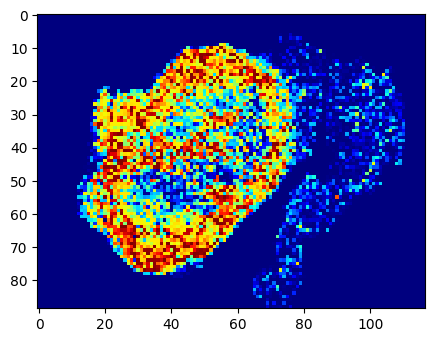

(16146, 1)
[[2.9802322e-08]
 [2.3643175e-05]
 [5.1349401e-05]
 ...
 [2.4024646e-04]
 [2.4197025e-04]
 [2.4941636e-04]]


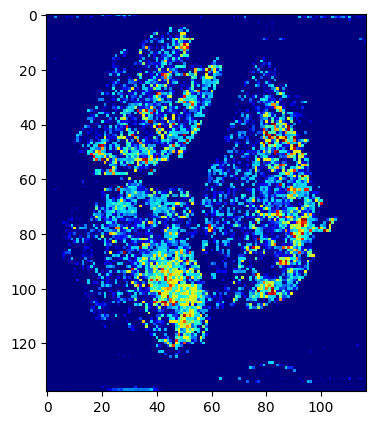

(15486, 1)
[[8.0774225e-05]
 [6.2674284e-05]
 [8.7817512e-05]
 ...
 [6.7293644e-05]
 [5.9277259e-05]
 [1.6005913e-04]]


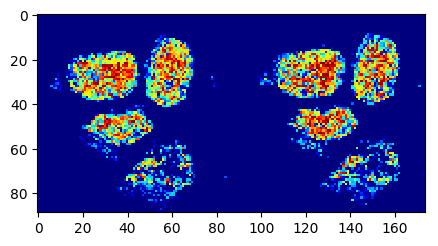

In [29]:
for i in range(len(test_images)):
  n = test_images[i].shape[1]//100
  print(avg_prob[i].shape)
  print(avg_prob[i])
  prob_image_vgg = np.reshape(avg_prob[i], (-1,n))
  plt.figure(figsize=(5,5), dpi=100)
  #plt.imshow(slide_image_test)
  plt.imshow(prob_image_vgg, cmap='jet', alpha=1)
  plt.show()

(42065, 1)
[[0.13352574]
 [0.14021508]
 [0.14028737]
 ...
 [0.14532335]
 [0.14381965]
 [0.23755823]]


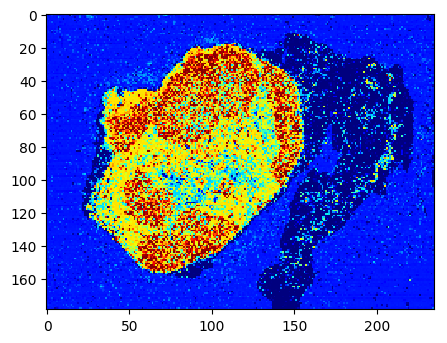

(42065, 1)


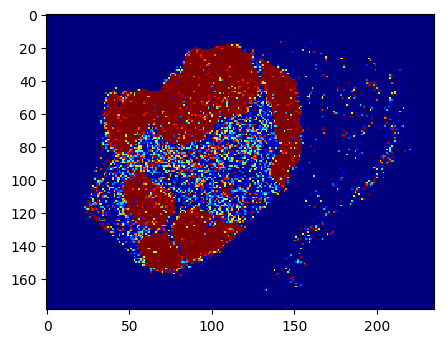

In [0]:
#Without ensemble
